In [3]:
import pandas as pd
import os
import pickle
import numpy as np
import warnings
import matplotlib.pyplot as plt
import shapefile
#import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
#from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
#from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import wkt
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats

ModuleNotFoundError: No module named 'shapefile'

### Data
http://gis.ny.gov/gisdata/inventories/details.cfm?DSID=932

In [3]:
data_dir = '/Users/saraprice/Documents/NYU/Research/EV_Charging_Stations/Data'
os.chdir(data_dir)

In [4]:
streets_shp = open(os.path.join(data_dir, 'Streets.shp/StreetSegment.shp'), "rb")
streets_dbf = open(os.path.join(data_dir, 'Streets.shp/StreetSegment.dbf'), "rb")
streets_reader = shapefile.Reader(shp=streets_shp, dbf=streets_dbf)

In [5]:
streets_reader.shapeType
shapes = streets_reader.shapes()
len(shapes)

1084336

In [6]:
streets_dbf = gpd.read_file(os.path.join(data_dir, 'Streets.shp/StreetSegment.dbf'))

#### Load NYC zip code boundaries shape file

In [77]:
zip_code_boundaries = gpd.read_file(os.path.join(data_dir, 'NYC_zip_codes/ZIP_CODE_040114.shp'), \
                                   crs={'init' :'epsg:26918'})

zip_code_boundaries = zip_code_boundaries[['ZIPCODE', 'geometry']]
zip_code_boundaries.to_crs(epsg=26918, inplace = True)
zip_code_boundaries.crs

<Projected CRS: EPSG:26918>
Name: NAD83 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 78°W to 72°W and NAD83 by country
- bounds: (-78.0, 28.28, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Limit Data to NYC Zip Codes

In [1]:
nyc_zips = pd.read_csv('NYC_zip_codes.csv')
nyc_zips_list = nyc_zips['zip_code'].astype(str).unique().tolist()

nyc_streets = streets_dbf[(streets_dbf['LeftPostal'].isin(nyc_zips_list)) |\
                          (streets_dbf['RightPosta'].isin(nyc_zips_list))] 
                                                                                                                                                

NameError: name 'pd' is not defined

In [92]:
nyc_streets.shape

(139010, 83)

In [93]:
nyc_streets1 = nyc_streets[['LeftPostal', 'RightPosta', 'SHIELD', 'HighwayNum', 'geometry']]\
                            .rename(columns = {'LeftPostal': 'Left_Postal', 'RightPosta': 'Right_Postal',\
                                              'SHIELD': 'Shield', 'HighwayNum': 'Highway_Number'})
print(nyc_streets1[nyc_streets1 ['Highway_Number'].isna()==False].shape)

(9565, 5)


In [94]:
nyc_streets1[nyc_streets1 ['Highway_Number'].isna()==False]['Shield'].value_counts()

I     3718
S     2712
P     2627
U      367
SH     137
C        4
Name: Shield, dtype: int64

In [97]:
highway_types = ['I', 'IC', 'P', 'SC', 'SH', 'U', 'UB', 'UC', 'S', 'C']
highways = nyc_streets1[nyc_streets1.Shield.isin(highway_types)]
print(highways.shape)
print(highways[highways['Highway_Number'].isna() == False].shape)

(9567, 5)
(9565, 5)


In [102]:
#### Find rows in the dataframe where LeftPostal and RightPostal aren't the same
highways_diff_left_right = highways[highways['Left_Postal']!= highways['Right_Postal']]
print(highways_diff_left_right.shape)
highways_diff_left_right.head()

(1711, 5)


,Left_Postal,Right_Postal,Shield,Highway_Number,geometry
752054,11692,11693,P,908L,"LINESTRING (600998.070 4493512.160, 600955.680..."
752057,11692,11693,P,908L,"LINESTRING (601028.750 4493515.690, 600998.070..."
752062,11692,11693,P,908L,"LINESTRING (601100.050 4493538.750, 601027.110..."
752086,11692,11693,P,908L,"LINESTRING (601210.690 4493550.130, 601106.470..."
752151,11692,11693,P,908L,"LINESTRING (600865.270 4493468.400, 600740.260..."


In [122]:
##Create dataframe of all unique combinations of left_postal and highways_number
left_zip_highways = highways[['Left_Postal', 'Highway_Number']].drop_duplicates()
print(left_zip_highways.shape)
print(left_zip_highways.head())
left_zip_highways = left_zip_highways.rename(columns = {'Left_Postal':'zip_code'})

##Create dataframe of all unique combinations of right_postal and highways_number
right_zip_highways = highways[['Right_Postal', 'Highway_Number']].drop_duplicates()
right_zip_highways = right_zip_highways.rename(columns = {'Right_Postal': 'zip_code'})
print(right_zip_highways.shape)

##Combine the two together and then drop duplicates to get a list of all unique zip_code and highway number 
zip_highways = pd.concat([right_zip_highways, left_zip_highways], axis = 0, ignore_index = True)
zip_highways = zip_highways.drop_duplicates()
zip_highways[zip_highways['zip_code']=='10462']

(349, 2)
       Left_Postal Highway_Number
752052       11693           908L
752054       11692           908L
752195       11693           907J
752211       11694           908L
752244       11693           900J
(354, 2)


,zip_code,Highway_Number
165,10462,907F
166,10462,1
169,10462,907H
171,10462,95
174,10462,295
178,10462,278
523,10462,908A
535,10462,678


In [126]:
zip_highways_grp = zip_highways.groupby('zip_code').count().rename(columns = {'Highway_Number': 'highway_count'})
zip_highways_grp['highway_bin'] = np.where(zip_highways_grp['highway_count']!=0, 1, 0)

In [127]:
zip_highways_grp['highway_bin'].value_counts()

1    161
0      1
Name: highway_bin, dtype: int64

<AxesSubplot:>

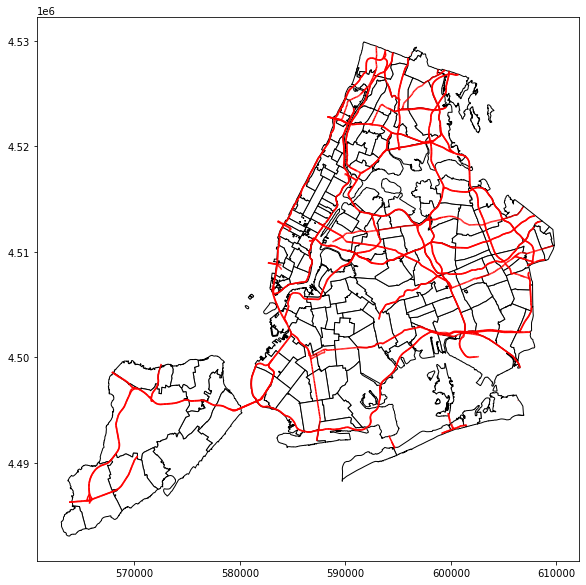

In [128]:
ax = zip_code_boundaries.plot(color = 'white', edgecolor = 'black', figsize = (12, 10))
highways.plot(ax = ax, color = 'red', label = 'Highway_Name')

### Create dataframe with all NYC zipcodes and whether or not there is a highway in a given zip code

In [134]:
nyc_zips.drop_duplicates(inplace = True)
nyc_zips1 = nyc_zips[['zip_code']].astype(str)
print(nyc_zips1.shape)
print(zip_highways_grp.shape)
streets_by_zip = pd.merge(nyc_zips1, zip_highways_grp, on = 'zip_code', how = 'left')
streets_by_zip[['highway_count', 'highway_bin']] = streets_by_zip[['highway_count', 'highway_bin']].fillna(0)

(240, 1)
(162, 2)


In [137]:
streets_by_zip['zip_code'] = streets_by_zip['zip_code'].astype(int)
streets_by_zip.to_csv(os.path.join(data_dir, 'highways_by_zip.csv'))

## Transportation Hub Data

In [ ]:
airport_data = {'airport': 1, 'zip_code': 11430,
               'airport': 1, 'zip_code': 11371}